# Figures derived from participant data

## imports

In [9]:
import json
#Pandas for saving datasets
import pandas as pd
#matplotlib for rendering
import matplotlib.pyplot as plt
#numpy for handeling matrix operations
import numpy as np
#time, to, well... keep track of time
import time
#iPython display for making sure we can render the frames
from IPython import display
#seaborn for rendering
import seaborn
import math
import os
import statistics as stat
import glob
import seaborn as sns
import matplotlib.ticker as mticker

#code from scipy documentation
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.ticker as mticker

sns.set(style='white')
sns.set_context("poster")

# Load Data

In [2]:
# Get data file names
cur_path = os.getcwd()
filenames = glob.glob(cur_path + "/data/*.csv")
# Read dframes into a list
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Filter

In [3]:
# get first dataframe and filter columns

filt_dfs = []
x = []
all_data = []
# concat all dframes into one dframe
for d in dfs:
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt','block_num'])
    # drop na, only 10s
    filt_dfs.append(my_df.dropna())
    x.append(len(my_df.dropna(subset = ['congruent'])) - len(my_df.dropna(subset = ['key_resp.rt'])))
    all_data.append(my_df.dropna(subset=['block_num']))

## concat #
full_dat = pd.concat(filt_dfs)
all_data = pd.concat(all_data)
#x_dat = pd.concat(x)


In [4]:
full_dat

congruent  Rand Tim  key_resp.rt block_num
1          0.0    1.3132     0.636110        5s
2          1.0    0.7037     0.709031        5s
3          0.0    0.8309     0.434464        5s
4          1.0    4.6764     0.553009        5s
5          0.0    4.6441     0.518856        5s
..         ...       ...          ...       ...
416        1.0    4.1302     0.473883        5s
419        0.0    4.1825     0.864461        5s
420        0.0    3.5785     0.386026        5s
421        0.0    1.9596     0.395578        5s
422        0.0    1.5706     0.367873        5s

[9350 rows x 4 columns]

# Trials where participants failed to respond

In [6]:
count = [i / 400 for i in x] ## 400 is the number of trials
print(f'average misses: {np.mean(count)}')

average misses: 0.10096153846153845


In [7]:
print(f'num subs: {len(dfs)}')

num subs: 26


In [12]:
running_totals = pd.DataFrame(columns=['block_num', 'NaNs for congruent = 1.0', 'NaNs for congruent = 0.0'])

# Iterate over the list of DataFrames
for d in dfs:
    # Filter relevant columns
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt', 'block_num'])

    # Drop rows with NaN in 'block_num'
    df = my_df.dropna(subset=['block_num'])

    # Group by block_num and calculate NaNs for congruent = 1.0 and congruent = 0.0
    nan_counts = df.groupby('block_num').apply(lambda group: pd.Series({
        'NaNs for congruent = 1.0': group[(group['congruent'] == 1.0) & (group['key_resp.rt'].isna())].shape[0],
        'NaNs for congruent = 0.0': group[(group['congruent'] == 0.0) & (group['key_resp.rt'].isna())].shape[0]
    }))

    # Reset index for better readability
    nan_counts = nan_counts.reset_index()

    # Merge with running totals, summing the counts
    running_totals = pd.concat([running_totals, nan_counts]).groupby('block_num', as_index=False).sum()
    
    #print(f'Proportion - valid / invalid: {}')


    #print(f"Updated Running Totals:")
    #print(running_totals)
running_totals

block_num NaNs for congruent = 1.0 NaNs for congruent = 0.0
0       10s                       92                      328
1        1s                       23                      102
2        3s                       46                      181
3        5s                       56                      222

### count of misses

In [13]:
sns.set(style='white')
sns.set_context("poster")

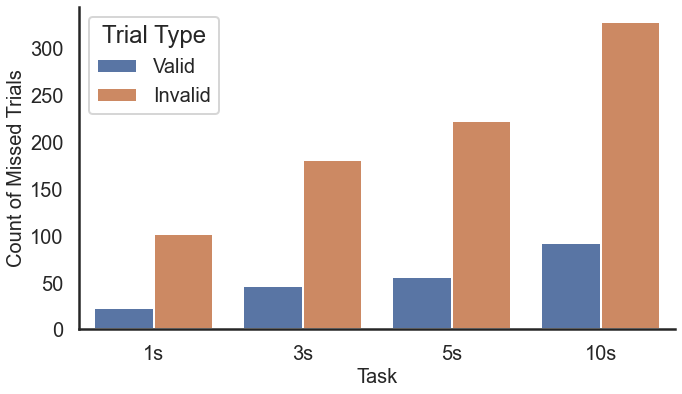

In [14]:
df = pd.DataFrame(running_totals)


# Sort the DataFrame by block_num in the desired order
desired_order = ['1s', '3s', '5s', '10s']
df['block_num'] = pd.Categorical(df['block_num'], categories=desired_order, ordered=True)
df = df.sort_values('block_num')

# Melt the DataFrame for Seaborn compatibility
df_melted = df.melt(id_vars='block_num', 
                    value_vars=['NaNs for congruent = 1.0', 'NaNs for congruent = 0.0'], 
                    var_name='Congruency', 
                    value_name='Count')

# Replace long labels with shorter ones
df_melted['Congruency'] = df_melted['Congruency'].replace({
    'NaNs for congruent = 1.0': 'Valid',
    'NaNs for congruent = 0.0': 'Invalid'
})

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='block_num', y='Count', hue='Congruency')

# Customize the plot
#plt.title('NaNs by Congruency and Block', fontsize=14)
plt.xlabel('Task', fontsize=20)
plt.ylabel('Count of Missed Trials', fontsize=20)
plt.legend(title='Trial Type', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

# Show the plot
plt.tight_layout()
sns.despine()
plt.show()

### Misses by foreperiod length

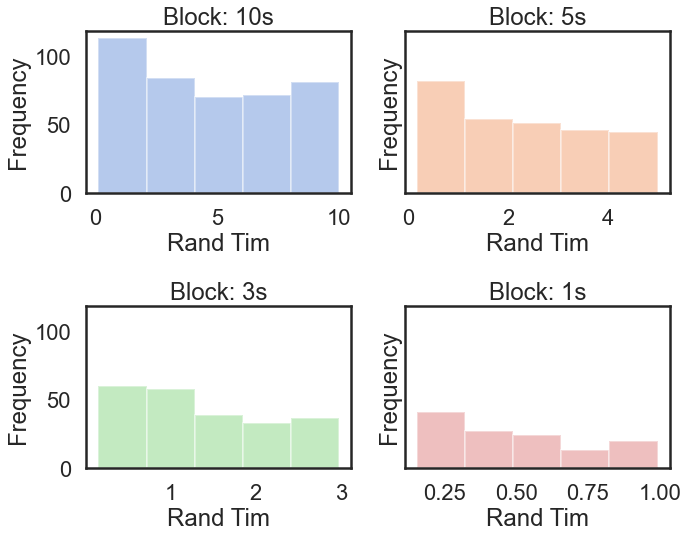

In [19]:
# get all misses
df = all_data[np.isnan(all_data['key_resp.rt'])]

# set binz
binz = 5


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Define unique block categories and colors
categories = df["block_num"].unique()
colors = sns.color_palette("muted", len(categories))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each histogram in its respective subplot
for ax, block, color in zip(axes, categories, colors):
    sns.distplot(
        df[df["block_num"] == block]["Rand Tim"],
        kde=False,  # No kernel density estimation
        bins=binz,  # Adjust bins as needed
        color=color,
        ax=ax,
    )
    ax.set_title(f"Block: {block}")
    ax.set_xlabel("Rand Tim")
    ax.set_ylabel("Frequency")

# Remove any unused subplots
if len(categories) < len(axes):
    for ax in axes[len(categories):]:
        ax.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Valid or invalid misses by foreperiod length

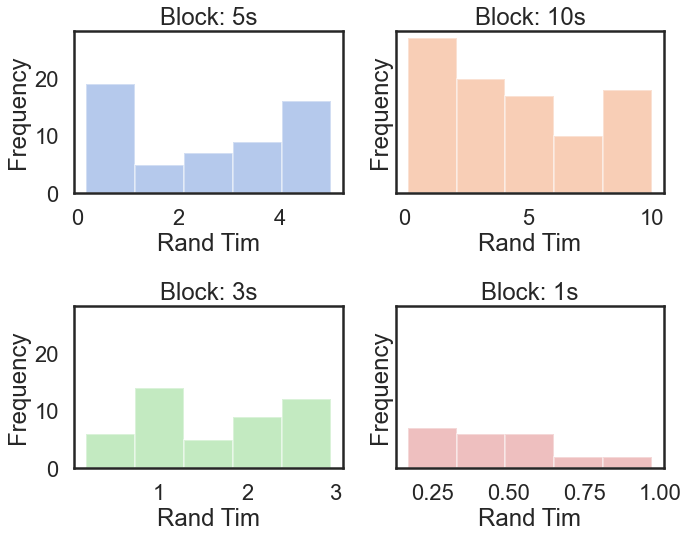

In [20]:
# get all misses
df = all_data[np.isnan(all_data['key_resp.rt'])]
# get invalid or valid
df = df[df['congruent'] == 1.0] ### CHANGE ME 
# set binz
binz = 5


# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Define unique block categories and colors
categories = df["block_num"].unique()
colors = sns.color_palette("muted", len(categories))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each histogram in its respective subplot
for ax, block, color in zip(axes, categories, colors):
    sns.distplot(
        df[df["block_num"] == block]["Rand Tim"],
        kde=False,  # No kernel density estimation
        bins=binz,  # Adjust bins as needed
        color=color,
        ax=ax,
    )
    ax.set_title(f"Block: {block}")
    ax.set_xlabel("Rand Tim")
    ax.set_ylabel("Frequency")

# Remove any unused subplots
if len(categories) < len(axes):
    for ax in axes[len(categories):]:
        ax.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Figure 3: By task

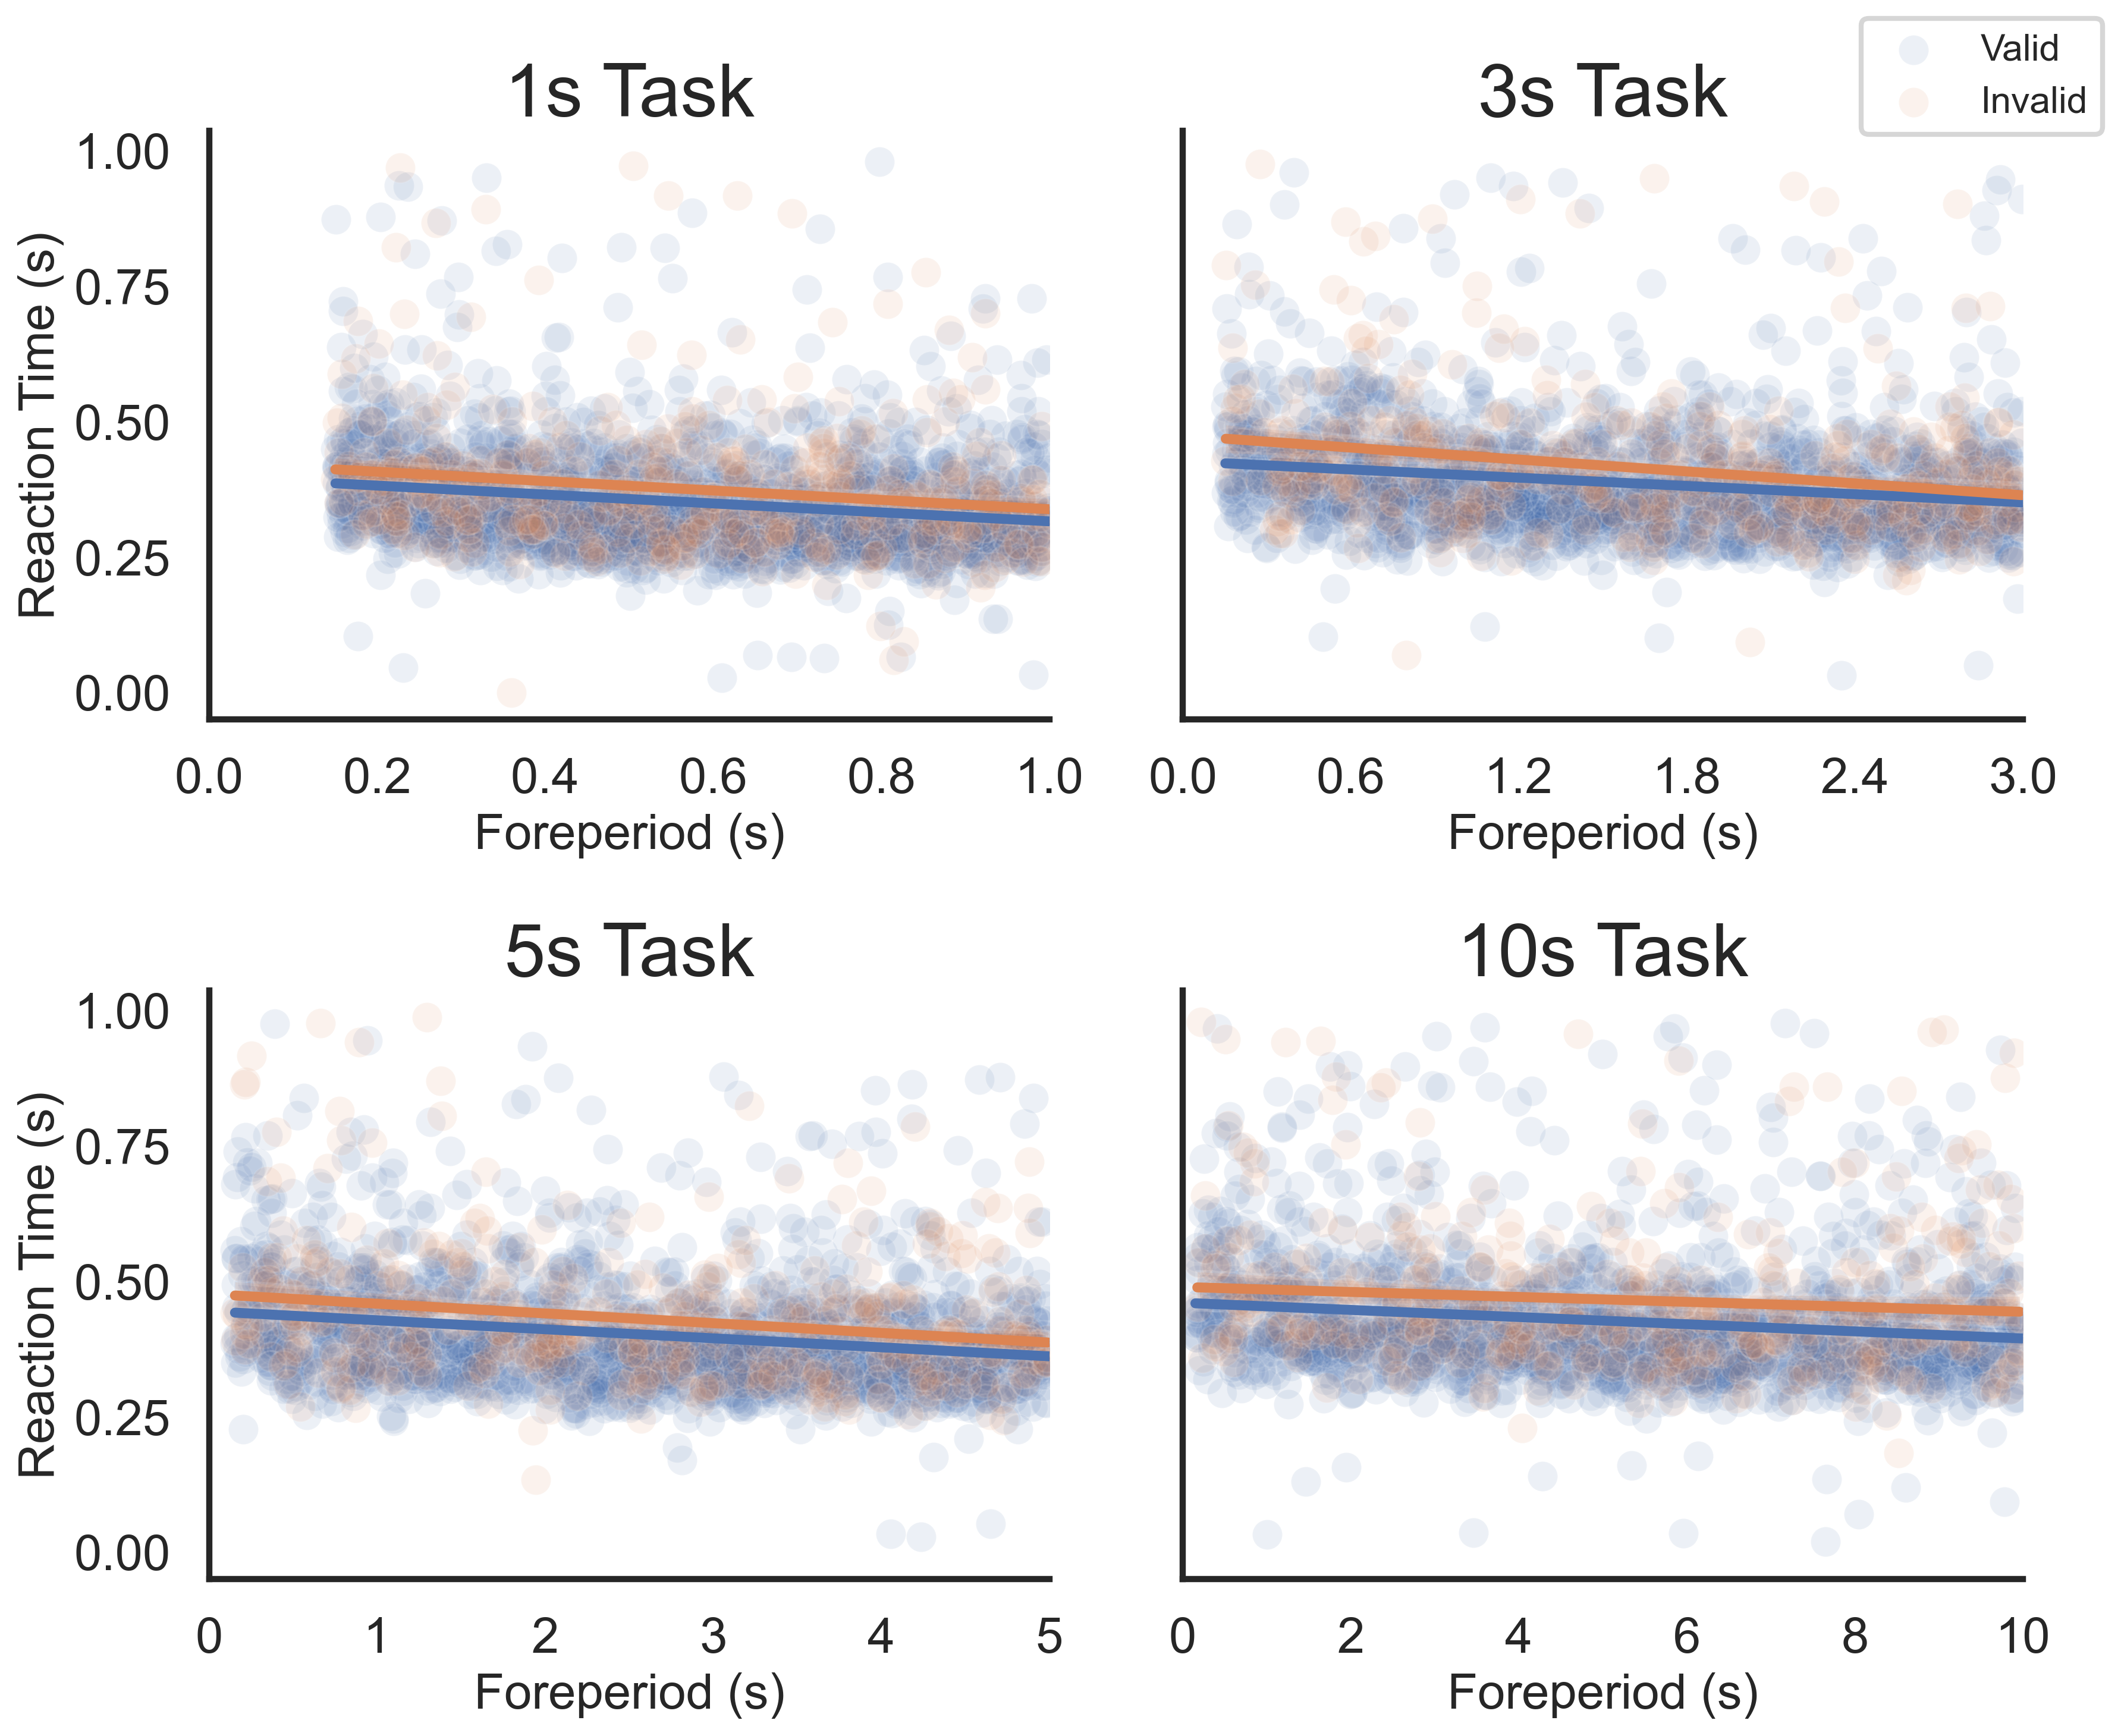

In [12]:
# Create a 2x2 subplot grid for each target condition number
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, dpi=300)

min_log_rt_threshold = -2.0  # Example threshold, adjust as needed


# Iterate over each target condition number
for i, targ_cond_num in enumerate([1, 3, 5, 10]):
    targ_cond_str = str(targ_cond_num) + 's'
    data = full_dat[full_dat['block_num'] == targ_cond_str]
    
    # Filter out small log(RT) values below the threshold
    data = data[data['key_resp.rt'] >= min_log_rt_threshold]


    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index

    # Scatter plot for congruent == 0 (Valid)
    sns.scatterplot(data=data[data['congruent'] == 0], x='Rand Tim', y='key_resp.rt', alpha=0.1, 
                    ax=axes[row, col], label='Valid', legend=False)
    sns.regplot(data=data[data['congruent'] == 0], x='Rand Tim', y='key_resp.rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Scatter plot for congruent == 1 (Invalid)
    sns.scatterplot(data=data[data['congruent'] == 1], x='Rand Tim', y='key_resp.rt', alpha=0.1, 
                    ax=axes[row, col], label='Invalid', legend=False)
    sns.regplot(data=data[data['congruent'] == 1], x='Rand Tim', y='key_resp.rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Set title and labels
    axes[row, col].set_title(f'{targ_cond_num}s Task', fontsize=30)
    axes[row, col].set_xlabel('Foreperiod (s)', fontsize=20)
    axes[row, col].set_ylabel('Reaction Time (s)', fontsize=20)
    
    axes[row, col].tick_params(axis='x', labelsize=20)
    axes[row, col].tick_params(axis='y', labelsize=20)

    # Set x-ticks using np.arange with 5 divisions, including the endpoint
    x_ticks = np.arange(0, targ_cond_num + targ_cond_num / 5, step=targ_cond_num / 5)
    axes[row, col].set_xticks(x_ticks)

# Add the global legend with handles and labels from the last subplot
handles, labels = axes[row, col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=15)

# Adjust layout and display
plt.tight_layout()
sns.despine()
plt.savefig('by_task_hum.png')
plt.show()


# Figure 4: Across task

In [30]:
sns.set(style='white', font_scale=2.2)
sns.set_context("poster")


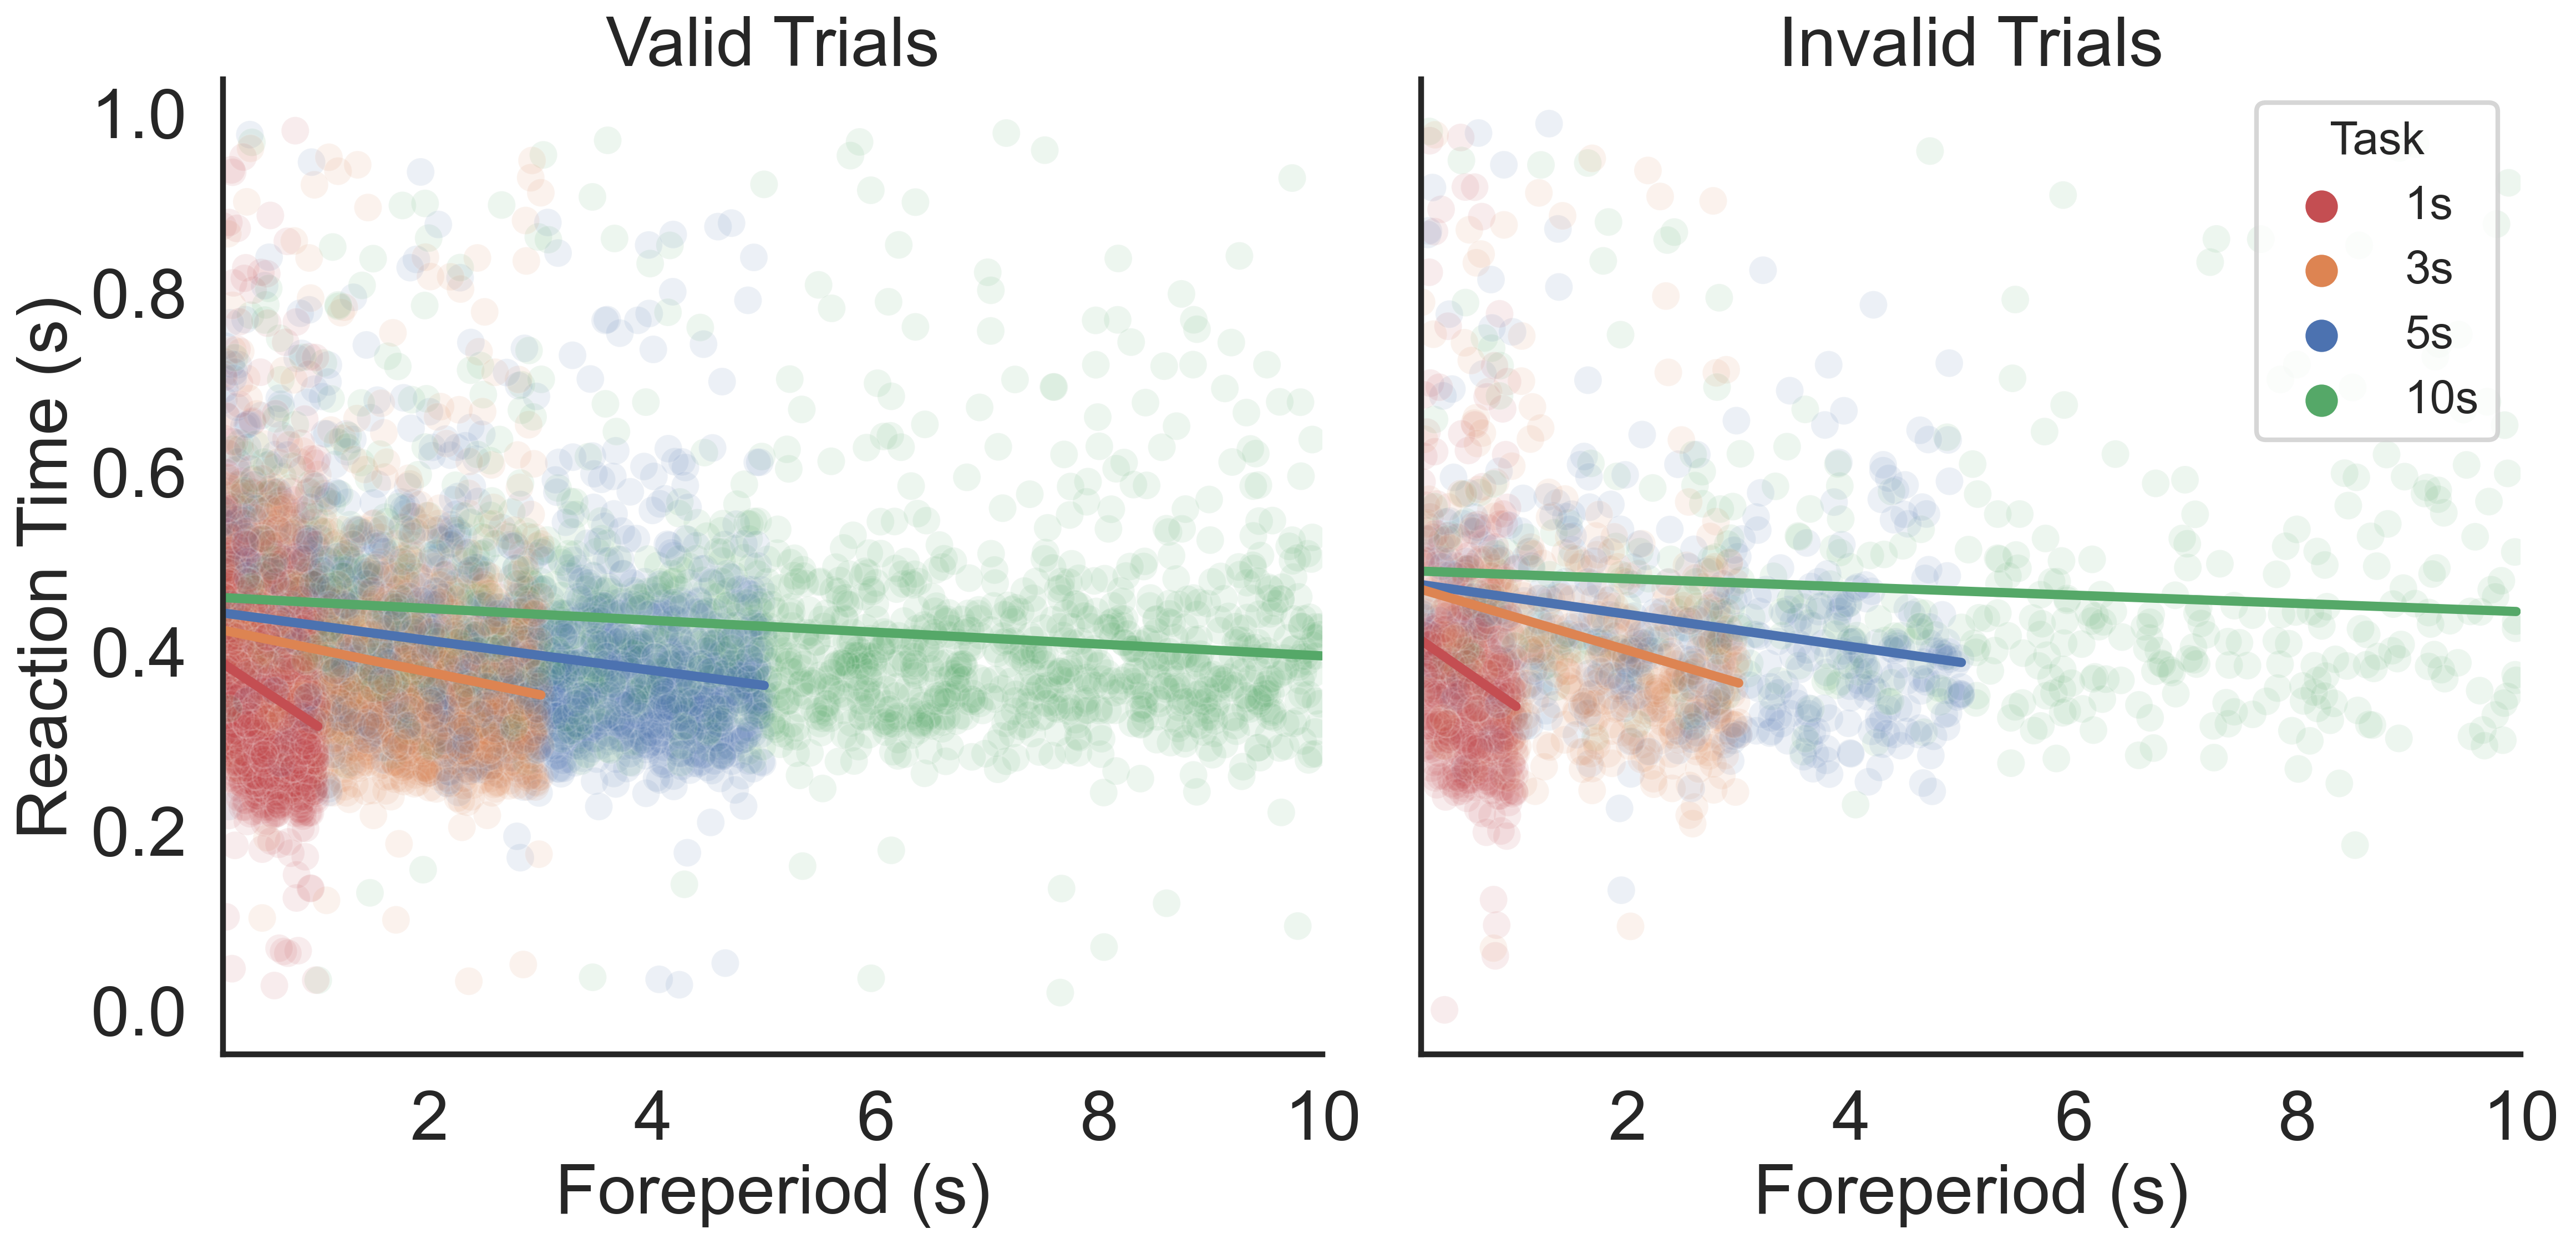

In [31]:
# Set plot size and font sizes
s1 = 30
s2 = 20


# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, dpi=300)

legend_order = [1, 3, 5, 10]

min_log_rt_threshold = -2


# Iterate over the unique 'congruent' values (0 and 1)
for i, congruent_value in enumerate([0, 1]):
    if congruent_value == 1:
        l = 'Invalid Trials'
    else:
        l = 'Valid Trials'
    # Subset data for the current 'congruent' value
    data = full_dat[full_dat['congruent'] == congruent_value]
    
    # Filter out small log(RT) values below the threshold
    data = data[data['key_resp.rt'] >= min_log_rt_threshold]
    
    # Create the seaborn regplot on the corresponding axis
    sns.scatterplot(data=data, x='Rand Tim', y='key_resp.rt', hue='block_num', alpha=0.1, ax=axes[i])
    # Plot separate regression lines for each 'block_num'
    for block in data['block_num'].unique():
        block_data = data[data['block_num'] == block]
        sns.regplot(data=block_data, x='Rand Tim', y='key_resp.rt', scatter=False, ax=axes[i], 
                    line_kws={"linewidth": 4}, label=f'Block {block} s', ci=None)

    # Set titles and labels for the current plot
    axes[i].set_title(f'{l}', fontsize=s1)
    axes[i].set_xlabel('Foreperiod (s)', fontsize=s1)

    # Set tick label sizes for x and y axes
    axes[i].tick_params(axis='x', labelsize=s1)
    axes[i].tick_params(axis='y', labelsize=s1)
    
    axes[i].set_xticks([2, 4, 6, 8, 10])

# Set a common y-axis label for both subplots
axes[0].set_ylabel('Reaction Time (s)', fontsize=s1)

# Customize the legend for the second subplot (axes[1])
handles, labels = axes[1].get_legend_handles_labels()
ordered_handles = [handles[labels.index(f'{block}s')] for block in legend_order if f'{block}s' in labels]
ordered_labels = [f'{block}s' for block in legend_order if f'{block}s' in labels]

# Place the legend only on the second graph, in the top-right, with custom ordering and fontsize
axes[1].legend(ordered_handles, ordered_labels, title='Task', fontsize=s2, title_fontsize=s2, loc='upper right')

# Remove the legend from the first graph
axes[0].get_legend().remove()

# Adjust layout and display the plots
plt.tight_layout()
sns.despine()
#plt.savefig('fig3_Valid.png')
plt.show()

# Figure 4: Data normalized by foreperiod length

In [40]:
# Fit model (dummy implementation for the example)
def fit_model_norm(x_data, y_data):
    # Initialize and fit the linear regression model
    model = LinearRegression()
    x_data = x_data.reshape(-1, 1)
    model.fit(x_data, y_data)
    return model.coef_, model.intercept_


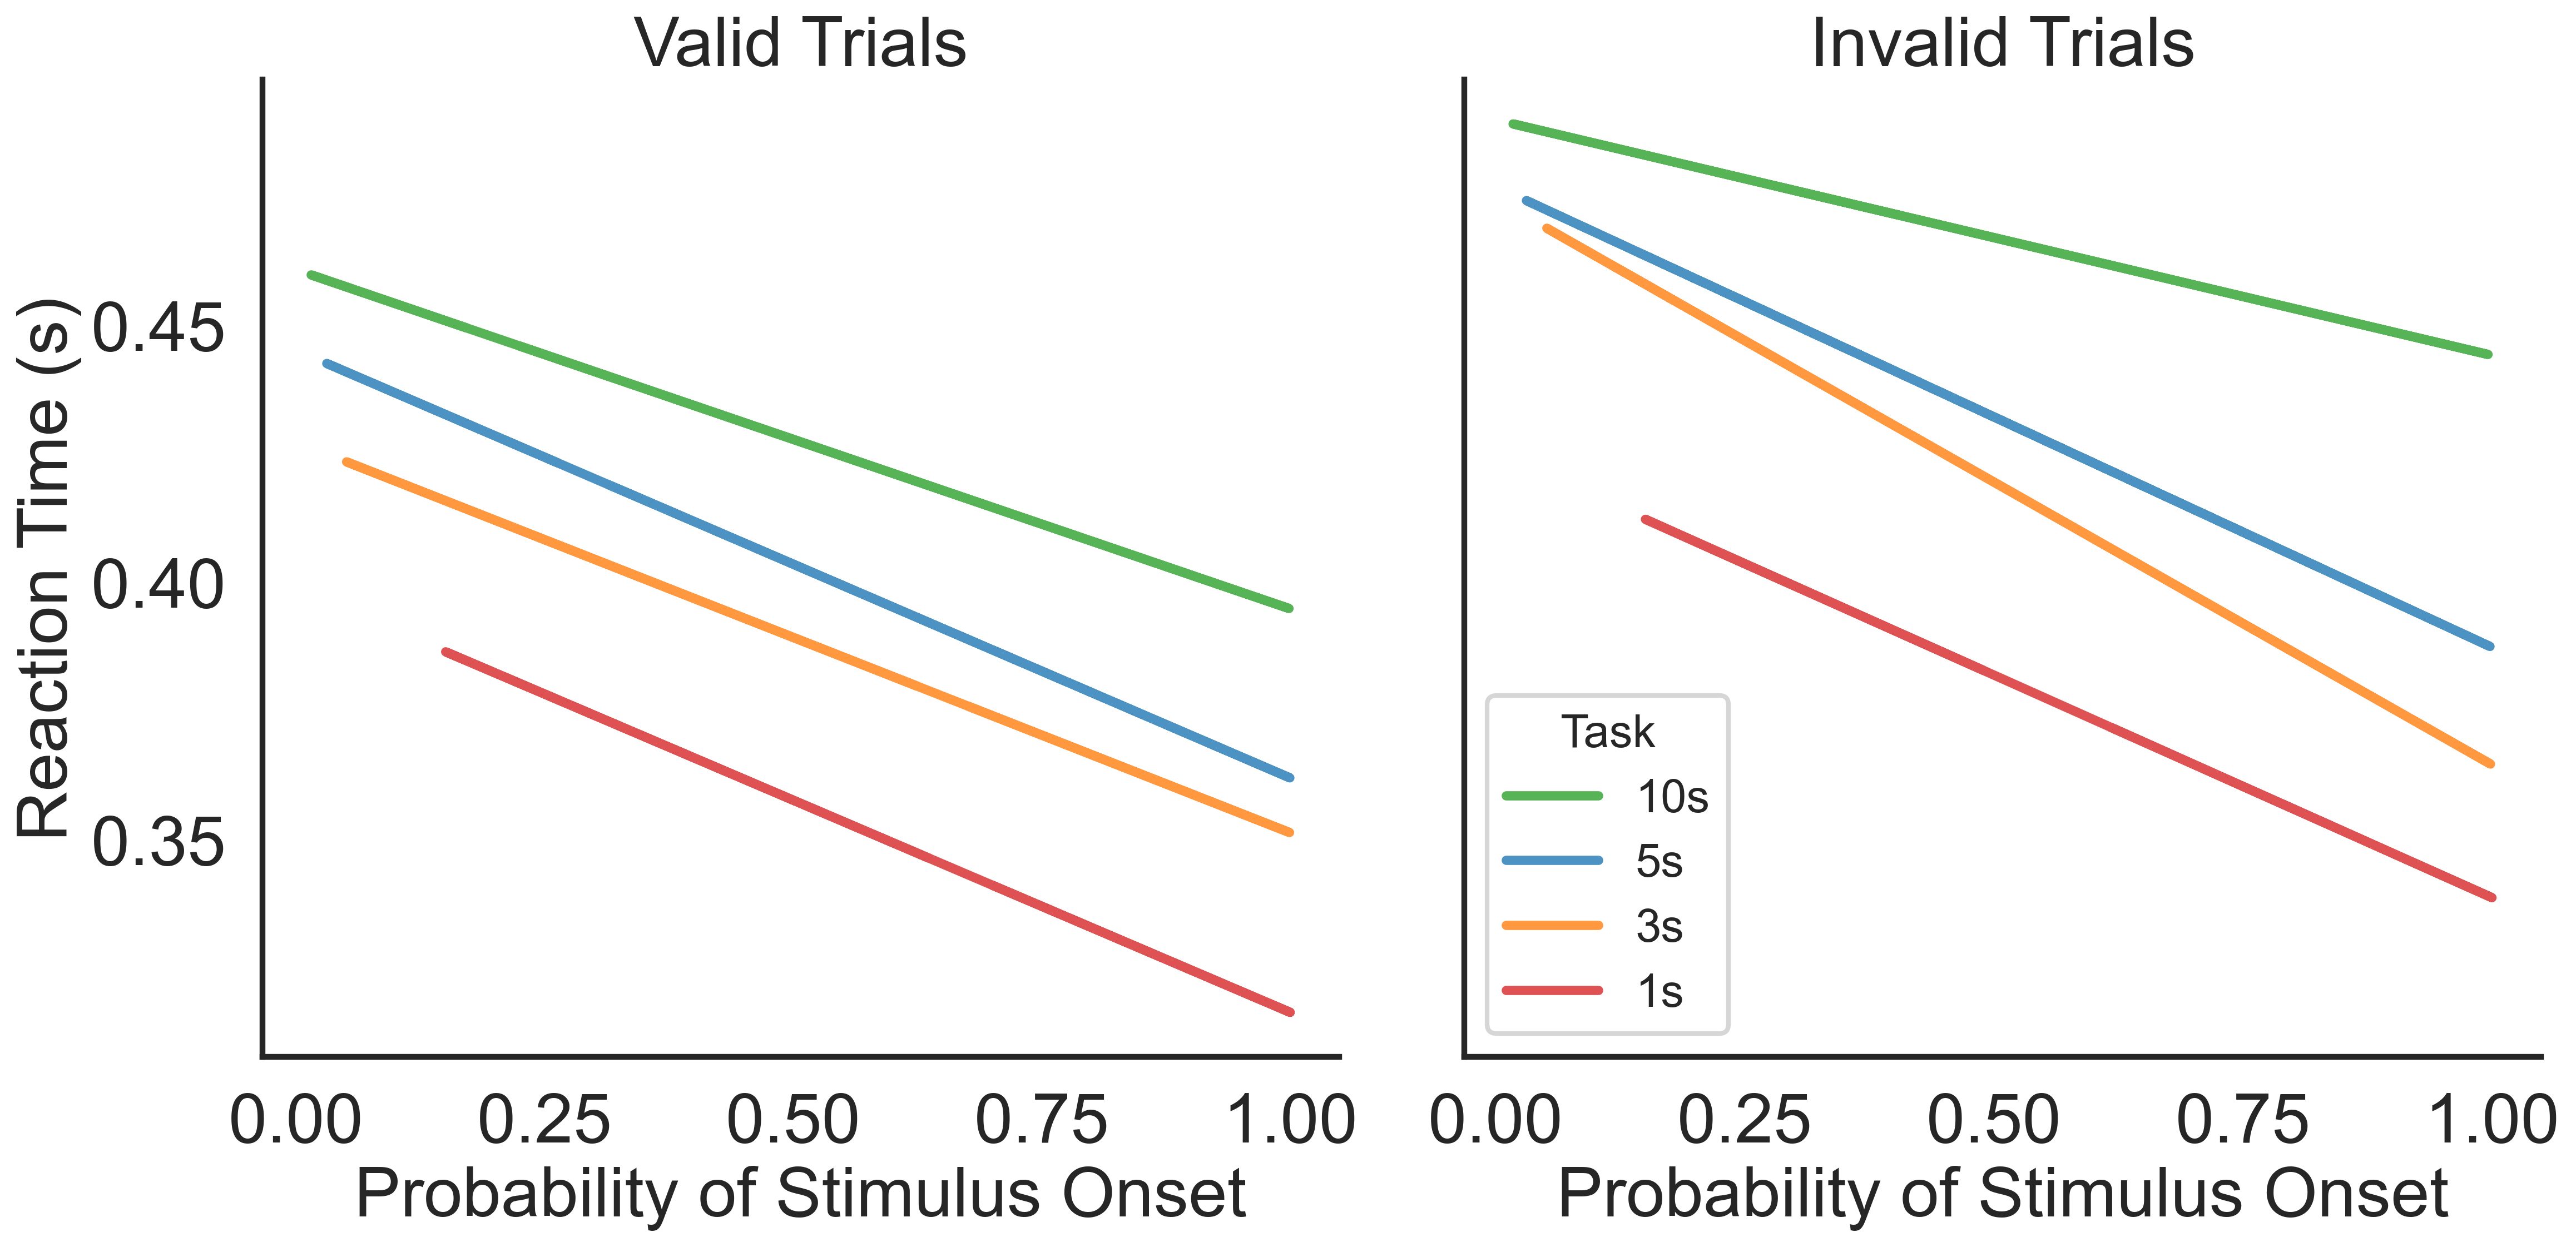

In [41]:

# Define the two trial types
trial_types = [0, 1]  # 0 for congruent (Valid), 1 for incongruent (Invalid)
base_cond_nums = [1, 3, 5, 10]
legend_order = [10, 5, 3, 1]  # Legend ordering
colors = {'10s': 'tab:green', '5s': 'tab:blue', '3s': 'tab:orange', '1s': 'tab:red'}  # Color mapping for conditions
s1 = 30
s2 = 20

# Create subplots: 1 row, 2 columns (one for each trial type)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, dpi=300)

# Iterate over each trial type
for i, trial_type in enumerate(trial_types):
    ax = axes[i]  # Get the current axis for plotting
    l = 'Valid' if trial_type == 0 else 'Invalid'
    
    lines = []  # To store line objects for legend
    labels = []  # To store labels for legend
    
    # Iterate over each base condition number
    for base_cond_num in base_cond_nums:
        base_cond_str = str(base_cond_num) + 's'

        # Extract data for the given base condition number
        condition_data = full_dat[(full_dat['congruent'] == trial_type) & (full_dat['block_num'] == base_cond_str)]
        
        y_data = condition_data[condition_data['key_resp.rt'] >= min_log_rt_threshold]

        # Normalize x_data by the base condition number or get probabilities
        x_data = np.array(condition_data['Rand Tim'] / base_cond_num)
        y_data = condition_data['key_resp.rt'].values
        


        # Fit model (assuming fit_model_norm is a function that fits a linear model)
        b_coef, b_int = fit_model_norm(x_data, y_data)

        # Plot the fit model line on the corresponding axis and store line objects
        line, = ax.plot(x_data, b_coef * x_data + b_int, color=colors[base_cond_str], linewidth=4, alpha=0.8, label=f'{base_cond_num}s')
        lines.append(line)  # Store the line object
        labels.append(f'{base_cond_num}s')  # Store the corresponding label
        
        # Set tick label sizes for x and y axes
        ax.tick_params(axis='x', labelsize=s1)
        ax.tick_params(axis='y', labelsize=s1)
        
        # Format x-axis tick labels to show only 2 decimal places
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    
    # Set labels and title for each subplot
    ax.set_title(f'{l} Trials', fontsize=s1)
    ax.set_xlabel('Probability of Stimulus Onset', fontsize=s1)
    if i == 0:
        ax.set_ylabel('Reaction Time (s)', fontsize=s1)  # Add y-label to the first subplot only

    # Reorder legend to match the desired order, but only add the legend to the second plot
    if i == 1:  # Add legend only on the second subplot (i.e., Invalid)
        reordered_lines = [lines[base_cond_nums.index(num)] for num in legend_order]
        reordered_labels = [labels[base_cond_nums.index(num)] for num in legend_order]
        ax.legend(reordered_lines, reordered_labels, title='Task', fontsize='small', title_fontsize='small')

# Add space between subplots and adjust layout
plt.tight_layout()
sns.despine()
#plt.savefig('probability_norm_fig.png')
plt.show()


# Figure 5: Sliding window ## 

In [5]:
def get_binned_rt(dat_con, dat_inc, intervals):
    '''
    return reaction times averaged per bin
    '''
    avs_con = []
    avs_incon = []
    for i in range(1,len(intervals)):
        av_con = dat_con['key_resp.rt'][(dat_con['Rand Tim']>intervals[i-1]) & (dat_con['Rand Tim']<intervals[i])].mean()
        av_inc = dat_inc['key_resp.rt'][(dat_inc['Rand Tim']>intervals[i-1]) & (dat_inc['Rand Tim']<intervals[i])].mean()
        #print("LB",intervals[i-1],"UB",intervals[i])
        #print('count_con:',len(dat_con['key_resp.rt'][(dat['Rand Tim']>intervals[i-1]) & (dat_con['Rand Tim']<intervals[i])]))
        #print('count_in:',len(dat_inc['key_resp.rt'][(dat_inc['Rand Tim']>intervals[i-1]) & (dat_inc['Rand Tim']<intervals[i])]))   
        avs_con.append(av_con)
        avs_incon.append(av_inc)
    return avs_con, avs_incon

def get_sliding_w_data(x_dat, y_dat, start, end, max_len, step):
    x_plot = []
    y_plot = []
    x_point = 0
    #while end < max_len:
    while x_point < max_len-step:
        ind = np.where((x_dat > start) & (x_dat < end))[0]
        y_plot.append(np.mean(y_dat[ind]))
        x_point = (start+ end) / 2
        x_plot.append(x_point)
        start += step
        end += step

    # last window
    ind = np.where((x_dat > start) & (x_dat < end))[0]
    y_plot.append(np.mean(y_dat[ind]))
    x_plot.append((start+ end) / 2)
    return x_plot, y_plot



In [6]:
def fit_partial_model(data, cond_len):
    # Define the predictor (X) and dependent variable (y)
    X = np.array(data['Rand Tim'][data['Rand Tim'] > (cond_len / 2)]).reshape(-1, 1)
    #y = data['key_resp.rt'] >5
    y = data['key_resp.rt'][data['Rand Tim'] > (cond_len / 2)]

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    return X, model.coef_, model.intercept_

def custom_round_ticks(x_ticks):
    # Round each tick to one decimal place only if there's a decimal part
    return [f"{tick:.1f}".rstrip('0').rstrip('.') for tick in x_ticks]

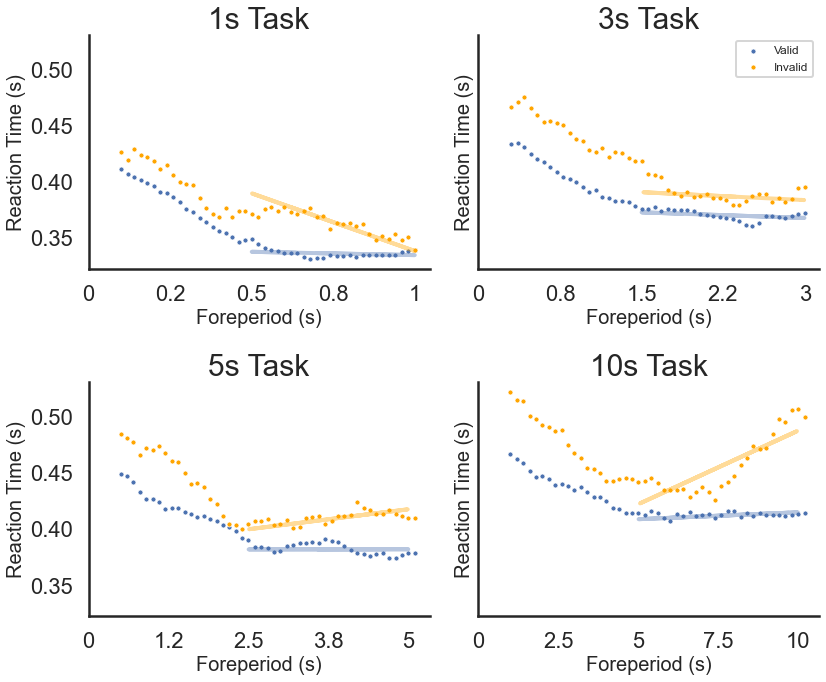

In [18]:
target_conditions = [1, 3, 5, 10]
sname = 'sliding_window.png'

# Create a 2x2 subplot grid for each target condition number
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
avs_con = []
avs_incon = []
x_vals = []

# Iterate over each target condition number
for i, targ_cond_num in enumerate(target_conditions):
    avs_con = []
    avs_incon = []
    x_vals = []
    
    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index
    
    targ_cond_str = str(targ_cond_num)+'s'

    dat_con = full_dat[(full_dat['congruent'] == 0) & (full_dat['block_num'] == targ_cond_str)]
    dat_inc = full_dat[(full_dat['congruent'] == 1) & (full_dat['block_num'] == targ_cond_str)]
    
    ## fit partial model ## 
    c_x_data, c_beta, c_int = fit_partial_model(dat_con, targ_cond_num)
    i_x_data, i_beta, i_int = fit_partial_model(dat_inc, targ_cond_num)

    # Get sliding window data 
    max_len = targ_cond_num
    i_len = targ_cond_num * .2 # length of bin size -- should be 20%
    start = 0
    end = start + i_len
    step = targ_cond_num * .02
    
    # DATA CON #
    x_dat = np.array(dat_con['Rand Tim'])
    y_dat = np.array(dat_con['key_resp.rt'])
    x_plot, y_plot = get_sliding_w_data(x_dat, y_dat, start, end, max_len, step)

    # Create scatter plot with reduced point size
    sns.scatterplot(x=x_plot, y=y_plot, label='Valid', ax=axes[row, col], color='b',s=25, legend=False)

    # DATA INC #
    x_dat = np.array(dat_inc['Rand Tim'])
    y_dat = np.array(dat_inc['key_resp.rt'])
    x_plot, y_plot = get_sliding_w_data(x_dat, y_dat, start, end, max_len, step)

    # Create scatter plot with reduced point size
    sns.scatterplot(x=x_plot, y=y_plot, label='Invalid', ax=axes[row, col], color='orange', s=25, legend=False)
    
    ## create lines of fit
    x_data = c_x_data.reshape(1,-1).flatten()
    axes[row, col].plot(x_data, c_beta[0] * x_data + c_int, color='b', linestyle='-', linewidth=4, alpha=.4)

    x_data = i_x_data.reshape(1,-1).flatten()
    axes[row, col].plot(x_data, i_beta[0] * x_data + i_int, color='orange', linestyle='-', linewidth=4, alpha=.4)

    
    # Set title and labels
    axes[row, col].set_title(f'{targ_cond_num}s Task', fontsize=30)
    axes[row, col].set_xlabel('Foreperiod (s)', fontsize=20)
    axes[row, col].set_ylabel('Reaction Time (s)', fontsize=20)
    
    # Adjust x-ticks
    x_ticks = np.arange(0, targ_cond_num + targ_cond_num/4, step=targ_cond_num / 4)
    axes[row, col].set_xticks(x_ticks)
    axes[row, col].set_xticklabels(custom_round_ticks(x_ticks))
    
   # Only show legend in top right subplot
    if i == 1:
        axes[row, col].legend(loc='upper right', fontsize=12)

# Adjust layout
plt.tight_layout()

# Increase tick label font size
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
sns.despine()
plt.savefig('sliding_window_hum.png')

# Show plot
plt.show()